# Creating DeepDreams

This notebook provides you with a complete code example that loads an image and the VGG16 pre-trained neural network, and uses them to create DeepDreams.


## Loading an Image

Load the example image titled `neuraltissue_with_colorlabels.png`. 

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [1]:
from PIL import Image

image_file = "neuraltissue_with_colorlabels.png"
im = Image.open(image_file).convert("RGB").resize((256, 256))

Then, plot this image.

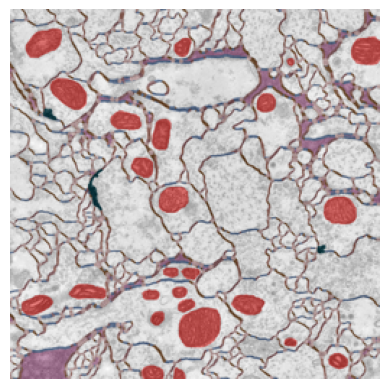

In [2]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.axis("off")
plt.savefig("fig_03_C1.pdf", bbox_inches='tight')  ### plt.show()

## Loading a Pre-Trained Neural Network

Import the VGG16 model, a pre-trained neural network known for its profi- ciency in image recognition tasks.

In [3]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval()
model.requires_grad_(False)

print(model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Define some variables with the mean and standard deviation values specific to the ImageNet dataset’s color channels.

In [4]:
import numpy as np
import torch

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

low = torch.tensor((- mean / std).reshape(1, -1, 1, 1))
high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

## Implementing the DeepDream Algorithm

The DeepDream algorithm is designed to optimize an image's representation by performing loss maximization using gradient ascent. By iterating over the image data and adjusting it in the direction that increases the activation of certain layers within a pretrained neural network, this function effectively "dreams up" new visual patterns and textures that amplify the features those layers detect. The process involves normalizing the image data (VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset), applying forward hooks to capture layer activations, calculating the loss, and then updating the image based on the gradients obtained. The result is an altered image that highlights the intricate patterns learned by the neural network.

Define functions to to convert an image to a tensor, and vice versa ...

In [5]:
import torchvision.transforms as tt

def image_to_tensor(im, mean, std):
    """Convert image to tensor."""
    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)]) 
    return normalize(im).unsqueeze(0).requires_grad_(True)

def tensor_to_image(image, mean, std):
    """Convert tensor to image."""
    denormalize = tt.Normalize(mean=- mean / std, std=1 / std)
    im_array = denormalize(image.data.clone().detach().squeeze()).numpy() 
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255)
    im_array = im_array.astype(np.uint8)
    return Image.fromarray(im_array, "RGB")

... convert the image into a PyTorch tensor ...

In [6]:
im_tensor = image_to_tensor(im, mean, std)

... perform the DeepDream gradient ascent ...

In [7]:
layer = model.features[1]
iter_num=100
eta=.1

hookdata = {}

def hook_func(layer, input, output): 
    """Hook for activations."""
    hookdata["activations"] = output

for _ in range(iter_num):
    handle = layer.register_forward_hook(hook_func) 
    try:
        _ = model(im_tensor) 
    except Exception as e:
        print(f"An error occurred during model predition: {e}")
    finally:
        handle.remove()
        
    loss = hookdata["activations"].mean()
    loss.backward()
    
    grad_mean = torch.mean(im_tensor.grad.data)
    grad_std = torch.std(im_tensor.grad.data)
    normalized_grad = (im_tensor.grad.data - grad_mean) / (grad_std + 1e-8)
    
    im_tensor.data += eta * normalized_grad
    
    im_tensor.grad.zero_()
    
    im_tensor.data.clamp_(low, high)

... convert the PyTorch tensor back to an image ...

In [8]:
im_deepdream = tensor_to_image(im_tensor, mean, std)

... and plot the resulting DeepDream.

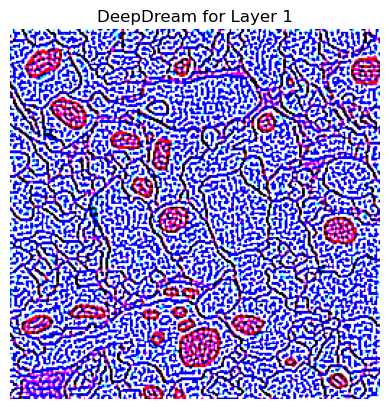

In [9]:
plt.imshow(im_deepdream)
plt.title("DeepDream for Layer 1")
plt.axis("off")
plt.savefig("fig_03_C2.pdf", bbox_inches='tight')  ### plt.show()

### Refactoring the DeepDream code as a Function

In [10]:
import torch

def deepdream(im, layer_index, iter_num=100, eta=.1): 
    """Generate DeepDream."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32) 
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    low = torch.tensor((-mean / std).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))
    
    im_tensor = image_to_tensor(im, mean, std)

    hookdata = {}

    def hook_func(layer, input, output): 
        """Hook for activations."""
        hookdata["activations"] = output

    layer = model.features[layer_index]
    for _ in range(iter_num):
        handle = layer.register_forward_hook(hook_func) 
        try:
            _ = model(im_tensor) 
        except Exception as e:
            print(f"An error occurred during model predition: {e}")
        finally:
            handle.remove()
            
        loss = hookdata["activations"].mean()
        loss.backward()
        
        grad_mean = torch.mean(im_tensor.grad.data)
        grad_std = torch.std(im_tensor.grad.data)
        normalized_grad = (im_tensor.grad.data - grad_mean) / (grad_std + 1e-8)
        
        im_tensor.data += eta * normalized_grad
        
        im_tensor.grad.zero_()
        
        im_tensor.data.clamp_(low, high)
        
    im_deepdream = tensor_to_image(im_tensor, mean, std)

    plt.imshow(im_deepdream)
    plt.title(f"DeepDream at Layer {layer_index}")
    plt.axis("off")
    plt.show()

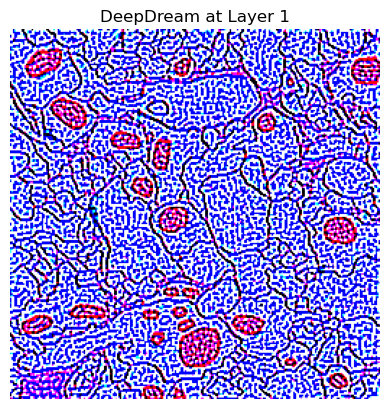

In [11]:
deepdream(im, layer_index=1, iter_num=100, eta=.1)

### Refectoring the DeepDream Function with a Context Manager for the Hook

In [12]:
class Fwd_Hook():
    """Forward hook."""
    
    def __init__(self, layer):
        """Initialize forward hook."""
        self.hook = layer.register_forward_hook(self.hook_func)
    
    def hook_func(self, layer, input, output):
        """Save activations."""
        self.activations = output

    def __enter__(self, *args):
        """Enter context and register hooks."""
        return self

    def __exit__(self, *args):
        """Exit context management and remove hook."""
        self.hook.remove()

In [13]:
def deepdream(im, layer_index, iter_num=100, eta=.1): 
    """Generate DeepDream."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32) 
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    low = torch.tensor((-mean / std).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))
    
    im_tensor = image_to_tensor(im, mean, std)

    hookdata = {}

    def hook_func(layer, input, output): 
        """Hook for activations."""
        hookdata["activations"] = output

    layer = model.features[layer_index]
    for _ in range(iter_num):
        with Fwd_Hook(layer) as fh:
            _ = model(im_tensor)
        
        loss = fh.activations.mean()
        loss.backward()        
        
        handle = layer.register_forward_hook(hook_func) 
        try:
            _ = model(im_tensor) 
        except Exception as e:
            print(f"An error occurred during model predition: {e}")
        finally:
            handle.remove()
            
        loss = hookdata["activations"].mean()
        loss.backward()
        
        grad_mean = torch.mean(im_tensor.grad.data)
        grad_std = torch.std(im_tensor.grad.data)
        normalized_grad = (im_tensor.grad.data - grad_mean) / (grad_std + 1e-8)
        
        im_tensor.data += eta * normalized_grad
        
        im_tensor.grad.zero_()
        
        im_tensor.data.clamp_(low, high)
        
    im_deepdream = tensor_to_image(im_tensor, mean, std)

    plt.imshow(im_deepdream)
    plt.title(f"DeepDream at Layer {layer_index}")
    plt.axis("off")
    plt.show()

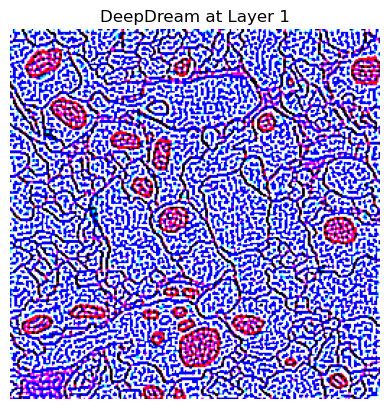

In [14]:
deepdream(im, layer_index=1, iter_num=100, eta=.1)

## Generating DeepDreams from Deeper Layers

In [15]:
###

def deepdream(im, layer_index, iter_num=100, eta=.1): 
    """Generate DeepDream."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32) 
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    low = torch.tensor((-mean / std).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))
    
    im_tensor = image_to_tensor(im, mean, std)

    hookdata = {}

    def hook_func(layer, input, output): 
        """Hook for activations."""
        hookdata["activations"] = output

    layer = model.features[layer_index]
    for _ in range(iter_num):
        with Fwd_Hook(layer) as fh:
            _ = model(im_tensor)
        
        loss = fh.activations.mean()
        loss.backward()        
        
        handle = layer.register_forward_hook(hook_func) 
        try:
            _ = model(im_tensor) 
        except Exception as e:
            print(f"An error occurred during model predition: {e}")
        finally:
            handle.remove()
            
        loss = hookdata["activations"].mean()
        loss.backward()
        
        grad_mean = torch.mean(im_tensor.grad.data)
        grad_std = torch.std(im_tensor.grad.data)
        normalized_grad = (im_tensor.grad.data - grad_mean) / (grad_std + 1e-8)
        
        im_tensor.data += eta * normalized_grad
        
        im_tensor.grad.zero_()
        
        im_tensor.data.clamp_(low, high)
        
    im_deepdream = tensor_to_image(im_tensor, mean, std)

    plt.imshow(im_deepdream)
    plt.title(f"DeepDream at Layer {layer_index}")
    plt.axis("off")
    ### plt.show()
    if layer_index == 3:
        plt.savefig("fig_03_C3a.pdf", bbox_inches='tight')
    elif layer_index == 6:
        plt.savefig("fig_03_C3b.pdf", bbox_inches='tight')
    elif layer_index == 8:
        plt.savefig("fig_03_C3c.pdf", bbox_inches='tight')
    elif layer_index == 11:
        plt.savefig("fig_03_C3d.pdf", bbox_inches='tight')
    elif layer_index == 18:
        plt.savefig("fig_03_C3e.pdf", bbox_inches='tight')
    elif layer_index == 29:
        plt.savefig("fig_03_C3f.pdf", bbox_inches='tight')

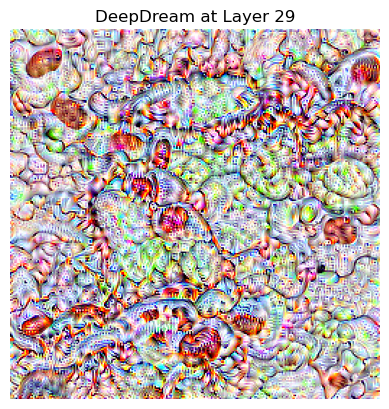

In [16]:
for layer_index in [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]:
    deepdream(im, layer_index, iter_num=100, eta=.1)

## Generating DeepDreams from Multiple Layers at Once

In [17]:
class Fwd_Hooks():
    """Forward hook."""
    
    def __init__(self, layers):
        """Initialize forward hooks."""
        self.hooks = []
        self.activations_list = []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))
    
    def hook_func(self, layer, input, output):
        """Save activations."""
        self.activations_list.append(output)

    def __enter__(self, *args):
        """Enter context and register hooks."""
        return self

    def __exit__(self, *args):
        """Exit context management and remove hooks."""
        for hook in self.hooks:
            hook.remove()

In [18]:
def deepdream(im, layer_indices, iter_num=100, eta=.1): 
    """Generate DeepDream."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32) 
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    low = torch.tensor((-mean / std).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))
    
    im_tensor = image_to_tensor(im, mean, std)

    hookdata = {}

    def hook_func(layer, input, output): 
        """Hook for activations."""
        hookdata["activations"] = output

    layers = [model.features[i] for i in layer_indices]
    for _ in range(iter_num):
        with Fwd_Hooks(layers) as fh:
            _ = model(im_tensor)
        
        losses = [activations.mean() for activations in fh.activations_list]
        loss = torch.stack(losses).sum()
        loss.backward()        
        
        handle = layer.register_forward_hook(hook_func) 
        try:
            _ = model(im_tensor) 
        except Exception as e:
            print(f"An error occurred during model predition: {e}")
        finally:
            handle.remove()
            
        loss = hookdata["activations"].mean()
        loss.backward()
        
        grad_mean = torch.mean(im_tensor.grad.data)
        grad_std = torch.std(im_tensor.grad.data)
        normalized_grad = (im_tensor.grad.data - grad_mean) / (grad_std + 1e-8)
        
        im_tensor.data += eta * normalized_grad
        
        im_tensor.grad.zero_()
        
        im_tensor.data.clamp_(low, high)
        
    im_deepdream = tensor_to_image(im_tensor, mean, std)

    plt.imshow(im_deepdream)
    plt.title(f"DeepDream at Layers {layer_indices}")
    plt.axis("off")
    plt.savefig("fig_03_C4.pdf", bbox_inches='tight')  ### plt.show()
    
    return im_deepdream

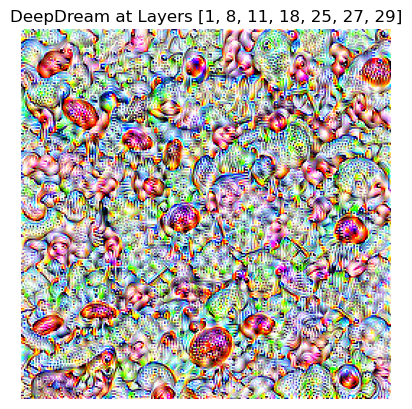

In [19]:
deepdream(im, layer_indices=[1, 8, 11, 18, 25, 27, 29], iter_num=100, eta=.1);

## Generating DeepDreams at Multiple Resolutions

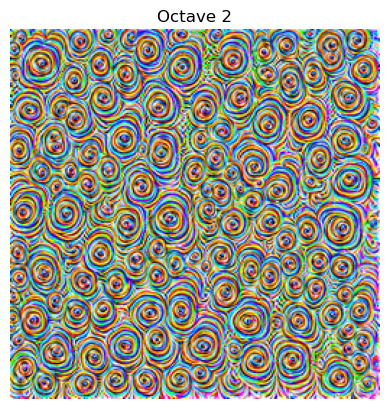

In [21]:
octave_scale = 1.4
layers_indices = [18]

original_size = im.size

im_deepdream = im
for octave in range(-2, 3):
    new_size = (
        int(original_size[0] * (octave_scale ** octave)),
        int(original_size[1] * (octave_scale ** octave)),
    )
    im_deepdream = im_deepdream.resize(new_size, Image.LANCZOS)
    
    im_deepdream = deepdream(im_deepdream, layers_indices,
                             iter_num=100, eta=.1)
    
    im_deepdream = im_deepdream.resize(original_size, Image.LANCZOS)

    plt.imshow(im_deepdream) 
    plt.title(f"Octave {octave}") 
    plt.axis("off")
    ### plt.show()
    if octave == -2:
        plt.savefig("fig_03_C5a.pdf", bbox_inches='tight')
    elif octave == 1:
        plt.savefig("fig_03_C5b.pdf", bbox_inches='tight')

## Generating DeepDreams at Multiple Resolutions Using Octaves and Multiple Layers

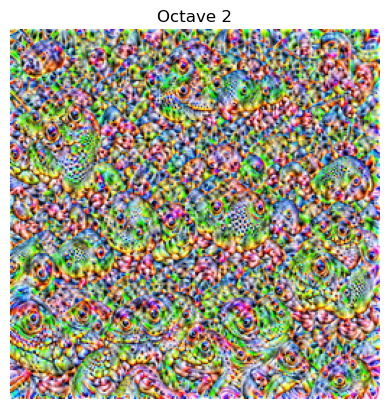

In [22]:
octave_scale = 1.4
layers_indices = [15, 18, 20, 22, 25, 27, 29]

original_size = im.size

im_deepdream = im
for octave in range(-2, 3):
    new_size = (
        int(original_size[0] * (octave_scale ** octave)),
        int(original_size[1] * (octave_scale ** octave)),
    )
    im_deepdream = im_deepdream.resize(new_size, Image.LANCZOS)
    
    im_deepdream = deepdream(im_deepdream, layers_indices,
                             iter_num=100, eta=.1)
    
    im_deepdream = im_deepdream.resize(original_size, Image.LANCZOS)

    plt.imshow(im_deepdream) 
    plt.title(f"Octave {octave}") 
    plt.axis("off")
    ### plt.show()
    if octave == -2:
        plt.savefig("fig_03_C6a.pdf", bbox_inches='tight')
    elif octave == 1:
        plt.savefig("fig_03_C6b.pdf", bbox_inches='tight')